In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm

In [2]:
# Implement from scratch the following normalization schemes. They should
# be implemented as a sub-class of torch.nn.Module.

# (a) Batch Normalization (BN) [3]
# (b) Instance Normalization (IN) [7]
# (c) Batch-Instance Normalization (BIN) [4]
# (d) Layer Normalization (LN) [1]
# (e) Group Normalization (GN) [8]

import torch
import torch.nn as nn

class NoNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(NoNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        return x

class BatchNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        # shape = (1, num_features, 1, 1)
        
    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class InstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(InstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

  

class BatchInstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchInstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        mean = x.mean(dim=[2, 3], keepdim=True)
        variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

    

class LayerNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(LayerNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class GroupNormalise(nn.Module):
    def __init__(self, num_features, num_groups=4, eps=1e-5, momentum=0.1):
        super(GroupNormalise, self).__init__()
        self.num_features = num_features
        self.num_groups = num_groups
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, self.num_groups, int(C / self.num_groups), H, W)
        mean = x.mean(dim=[1, 2, 3], keepdim=True)
        variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = x.view(N, C, H, W)
        x = self.gamma * x + self.beta
        return x

In [3]:
def norms(dimension, norm_type):
    if norm_type == 'none':
        return NoNormalise(dimension)
    elif norm_type == 'batch':
        return BatchNormalise(dimension)
    elif norm_type == 'instance':
        return InstanceNormalise(dimension)
    elif norm_type == 'batchinstance':
        return BatchInstanceNormalise(dimension)
    elif norm_type == 'layer':
        return LayerNormalise(dimension)
    elif norm_type == 'group':
        return GroupNormalise(dimension)
    else:
        raise ValueError('Invalid norm type')
    

class resd_block(nn.Module):
    def __init__(self, in_chs, out_chs, downsampling=None, stride=1, norm_type='none'):
        super(resd_block, self).__init__()
        self.conv1 = nn.Conv2d(in_chs, out_chs, kernel_size=3, stride=stride, padding=1)
        self.bn1 = norms(out_chs, norm_type)
        self.conv2 = nn.Conv2d(out_chs, out_chs, kernel_size=3, stride=1, padding=1)
        self.bn2 = norms(out_chs, norm_type)
        self.downsampling = downsampling
        self.relu = nn.ReLU()
        self.out_chs = out_chs

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampling is not None:
            identity = self.downsampling(x)
        out += identity
        out = self.relu(out)
        return out
    

class resnet(nn.Module): # n layers of blocks, r classes
    def __init__(self, resd_block, layers, img_chs, r, norm_type):
        super(resnet, self).__init__()
        self.in_chs = 16
        self.conv1 = nn.Conv2d(img_chs, 16, kernel_size=3, stride=1, padding=1)
        self.bn = norms(16, norm_type)
        self.relu = nn.ReLU()
        self.layer1 = self.add_layer(resd_block, 16, layers[0], 1, norm_type)
        self.layer2 = self.add_layer(resd_block, 32, layers[1], 2, norm_type)
        self.layer3 = self.add_layer(resd_block, 64, layers[2], 2, norm_type)
        self.avg_pool = nn.AvgPool2d(kernel_size=64)
        self.fc = nn.Linear(64, r)

    def add_layer(self, resd_block, out_chs, n, stride, norm_type):
        downsampling = None
        if (stride != 1) or (self.in_chs != out_chs):
            downsampling = nn.Sequential(nn.Conv2d(self.in_chs, out_chs, kernel_size=3, stride=stride, padding=1), norms(out_chs, norm_type))
        layers = []
        layers.append(resd_block(self.in_chs, out_chs, downsampling, stride, norm_type))
        self.in_chs = out_chs

        for i in range(1, n):
            layers.append(resd_block(self.in_chs, out_chs, norm_type=norm_type))
            
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

def final_resnet(img_chs, r, n, norm_type):
    return resnet(resd_block, [n, n, n], img_chs, r, norm_type)

In [4]:
num_epochs = 50 
num_workers = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


Train Data:  29417
------------------------Training Started------------------------


100%|██████████| 230/230 [03:41<00:00,  1.04it/s]


Epoch:  0 Train Loss_8:  0.3478876723144803 Train Accuracy_8:  17.649658360811777
Epoch:  0 Train Loss_128:  0.018729510514632515 Train Accuracy_128:  29.336778053506475
---------------------------------------------------------------


100%|██████████| 230/230 [03:41<00:00,  1.04it/s]


Epoch:  1 Train Loss_8:  0.3033278867600829 Train Accuracy_8:  27.188360471836013
Epoch:  1 Train Loss_128:  0.016914886746995126 Train Accuracy_128:  34.565047421558965
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.04it/s]


Epoch:  2 Train Loss_8:  0.280117124632124 Train Accuracy_8:  32.09028792874869
Epoch:  2 Train Loss_128:  0.015820262433476204 Train Accuracy_128:  38.280586055682086
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  3 Train Loss_8:  0.2626879792949841 Train Accuracy_8:  35.51347860080906
Epoch:  3 Train Loss_128:  0.015181963556493719 Train Accuracy_128:  40.46639698133732
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.04it/s]


Epoch:  4 Train Loss_8:  0.25028675270626827 Train Accuracy_8:  38.627324336268146
Epoch:  4 Train Loss_128:  0.014390463353613603 Train Accuracy_128:  43.86919128395146
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.04it/s]


Epoch:  5 Train Loss_8:  0.23949055416674708 Train Accuracy_8:  40.6125709623687
Epoch:  5 Train Loss_128:  0.013772655425723503 Train Accuracy_128:  46.83006424856376
---------------------------------------------------------------


100%|██████████| 230/230 [03:41<00:00,  1.04it/s]


Epoch:  6 Train Loss_8:  0.23045974641417316 Train Accuracy_8:  42.74399156950063
Epoch:  6 Train Loss_128:  0.013252352543268172 Train Accuracy_128:  48.99547880477275
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.04it/s]


Epoch:  7 Train Loss_8:  0.22220192987062906 Train Accuracy_8:  44.83122004283238
Epoch:  7 Train Loss_128:  0.01277113298379893 Train Accuracy_128:  50.973926641057886
---------------------------------------------------------------


100%|██████████| 230/230 [03:41<00:00,  1.04it/s]


Epoch:  8 Train Loss_8:  0.21456786027215463 Train Accuracy_8:  47.21759526804229
Epoch:  8 Train Loss_128:  0.012342601231416386 Train Accuracy_128:  52.74841078288065
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  9 Train Loss_8:  0.20735085009312845 Train Accuracy_8:  48.822109664479726
Epoch:  9 Train Loss_128:  0.011951980039046274 Train Accuracy_128:  54.30193425570249
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  10 Train Loss_8:  0.20238308188754534 Train Accuracy_8:  50.03229425162321
Epoch:  10 Train Loss_128:  0.0115829921779405 Train Accuracy_128:  55.753475881293134
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  11 Train Loss_8:  0.19612823300035498 Train Accuracy_8:  51.69799775639936
Epoch:  11 Train Loss_128:  0.011279038222004588 Train Accuracy_128:  57.45657273005405
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  12 Train Loss_8:  0.19032573603504183 Train Accuracy_8:  53.771628650100276
Epoch:  12 Train Loss_128:  0.01103004647552649 Train Accuracy_128:  58.8061325084135
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  13 Train Loss_8:  0.18566469633024482 Train Accuracy_8:  55.02940476595166
Epoch:  13 Train Loss_128:  0.010744786892254315 Train Accuracy_128:  59.71717034367883
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  14 Train Loss_8:  0.18129355805036176 Train Accuracy_8:  56.12061053132542
Epoch:  14 Train Loss_128:  0.010523468915523911 Train Accuracy_128:  60.702994866913684
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  15 Train Loss_8:  0.17843338148527524 Train Accuracy_8:  56.84128225175918
Epoch:  15 Train Loss_128:  0.010348560691191857 Train Accuracy_128:  61.66502362579461
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  16 Train Loss_8:  0.17405091182385715 Train Accuracy_8:  58.024271679641025
Epoch:  16 Train Loss_128:  0.01017481885339068 Train Accuracy_128:  62.17493286195057
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  17 Train Loss_8:  0.170669129627722 Train Accuracy_8:  59.329639324200286
Epoch:  17 Train Loss_128:  0.010013962438754352 Train Accuracy_128:  62.76302818098378
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  18 Train Loss_8:  0.1681096292392651 Train Accuracy_8:  59.45541693578543
Epoch:  18 Train Loss_128:  0.009881181177464187 Train Accuracy_128:  63.442907162525074
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  19 Train Loss_8:  0.1658006150373106 Train Accuracy_8:  60.46503722337424
Epoch:  19 Train Loss_128:  0.00974179361347728 Train Accuracy_128:  63.77944725838801
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  20 Train Loss_8:  0.16305448825307392 Train Accuracy_8:  61.236699867423596
Epoch:  20 Train Loss_128:  0.009669138775175917 Train Accuracy_128:  64.4083353163137
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  21 Train Loss_8:  0.16227732512617546 Train Accuracy_8:  61.399870822993506
Epoch:  21 Train Loss_128:  0.009617487799567346 Train Accuracy_128:  64.29275588945168
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  22 Train Loss_8:  0.16060477505729706 Train Accuracy_8:  61.99136553693443
Epoch:  22 Train Loss_128:  0.009498948686917245 Train Accuracy_128:  64.775469966346
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  23 Train Loss_8:  0.15919150104860513 Train Accuracy_8:  62.273515314274064
Epoch:  23 Train Loss_128:  0.00948002267330424 Train Accuracy_128:  65.1528028011014
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  24 Train Loss_8:  0.15803765160617536 Train Accuracy_8:  62.34830200224361
Epoch:  24 Train Loss_128:  0.009428593189422865 Train Accuracy_128:  65.58792534928783
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  25 Train Loss_8:  0.15768557688670962 Train Accuracy_8:  62.72563483699901
Epoch:  25 Train Loss_128:  0.009372018124920493 Train Accuracy_128:  65.71030356596526
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  26 Train Loss_8:  0.15646802926659645 Train Accuracy_8:  63.13356222592379
Epoch:  26 Train Loss_128:  0.009338236199150834 Train Accuracy_128:  65.72390114559609
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  27 Train Loss_8:  0.15596192011021254 Train Accuracy_8:  63.075772512492776
Epoch:  27 Train Loss_128:  0.00927194407208551 Train Accuracy_128:  66.21681340721352
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  28 Train Loss_8:  0.155895082017204 Train Accuracy_8:  63.13356222592379
Epoch:  28 Train Loss_128:  0.009196468830011385 Train Accuracy_128:  66.33919162389094
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  29 Train Loss_8:  0.15530598548582217 Train Accuracy_8:  62.97379066526159
Epoch:  29 Train Loss_128:  0.009109551321744116 Train Accuracy_128:  66.67573171975388
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.04it/s]


Epoch:  30 Train Loss_8:  0.15569952418139008 Train Accuracy_8:  63.12336404120067
Epoch:  30 Train Loss_128:  0.0090636149113137 Train Accuracy_128:  67.24683006424857
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  31 Train Loss_8:  0.1544793125166139 Train Accuracy_8:  63.466702926879016
Epoch:  31 Train Loss_128:  0.00895337653921135 Train Accuracy_128:  67.14824761192509
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  32 Train Loss_8:  0.15366830477137638 Train Accuracy_8:  63.50409627086378
Epoch:  32 Train Loss_128:  0.00891359435444998 Train Accuracy_128:  67.29102219804875
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  33 Train Loss_8:  0.15356734731781146 Train Accuracy_8:  63.510895060679196
Epoch:  33 Train Loss_128:  0.008825582020886633 Train Accuracy_128:  68.19526124349866
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  34 Train Loss_8:  0.15259148280021712 Train Accuracy_8:  63.64687085698746
Epoch:  34 Train Loss_128:  0.008673091328970357 Train Accuracy_128:  68.3244382499915
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  35 Train Loss_8:  0.15145285826883167 Train Accuracy_8:  63.7760478634803
Epoch:  35 Train Loss_128:  0.008604243316158267 Train Accuracy_128:  69.0111160213482
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  36 Train Loss_8:  0.1505552321235794 Train Accuracy_8:  64.21117041166671
Epoch:  36 Train Loss_128:  0.008467981584918982 Train Accuracy_128:  69.51422646768876
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  37 Train Loss_8:  0.14980852095184877 Train Accuracy_8:  64.0887921949893
Epoch:  37 Train Loss_128:  0.008343328237655141 Train Accuracy_128:  69.95614780569058
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  38 Train Loss_8:  0.1487784846458671 Train Accuracy_8:  64.50011897882177
Epoch:  38 Train Loss_128:  0.008244509022966194 Train Accuracy_128:  70.24849576775334
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  39 Train Loss_8:  0.14666089739640484 Train Accuracy_8:  65.11540945711664
Epoch:  39 Train Loss_128:  0.008107820396278751 Train Accuracy_128:  70.58163646870858
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  40 Train Loss_8:  0.14569029399978436 Train Accuracy_8:  65.05761974368562
Epoch:  40 Train Loss_128:  0.007981317570602019 Train Accuracy_128:  71.48587551415848
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  41 Train Loss_8:  0.14430225807519337 Train Accuracy_8:  65.54713261039535
Epoch:  41 Train Loss_128:  0.007863374988660816 Train Accuracy_128:  71.77142468640582
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  42 Train Loss_8:  0.14254486029805888 Train Accuracy_8:  65.59132474419553
Epoch:  42 Train Loss_128:  0.007681137629943162 Train Accuracy_128:  72.42070911377775
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  43 Train Loss_8:  0.1407549322476121 Train Accuracy_8:  66.56015229289186
Epoch:  43 Train Loss_128:  0.007614043521845443 Train Accuracy_128:  72.75724920964069
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  44 Train Loss_8:  0.1384759416044717 Train Accuracy_8:  67.07346092395554
Epoch:  44 Train Loss_128:  0.007476395752135191 Train Accuracy_128:  73.40653363701261
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  45 Train Loss_8:  0.1357860810547904 Train Accuracy_8:  67.71594656151206
Epoch:  45 Train Loss_128:  0.007267037915329227 Train Accuracy_128:  74.1476017268926
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  46 Train Loss_8:  0.13430101424430316 Train Accuracy_8:  67.99129754903626
Epoch:  46 Train Loss_128:  0.007114677580839821 Train Accuracy_128:  74.64391338341775
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  47 Train Loss_8:  0.13192029051979348 Train Accuracy_8:  68.61678621205427
Epoch:  47 Train Loss_128:  0.007080978386730455 Train Accuracy_128:  74.94645953020363
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  48 Train Loss_8:  0.12887440084353396 Train Accuracy_8:  69.35785430193425
Epoch:  48 Train Loss_128:  0.006783563873034126 Train Accuracy_128:  75.97647618723867
---------------------------------------------------------------


100%|██████████| 230/230 [03:42<00:00,  1.03it/s]


Epoch:  49 Train Loss_8:  0.12700071408683627 Train Accuracy_8:  69.68419621307407
Epoch:  49 Train Loss_128:  0.006743507033181871 Train Accuracy_128:  76.21443383077812
---------------------------------------------------------------


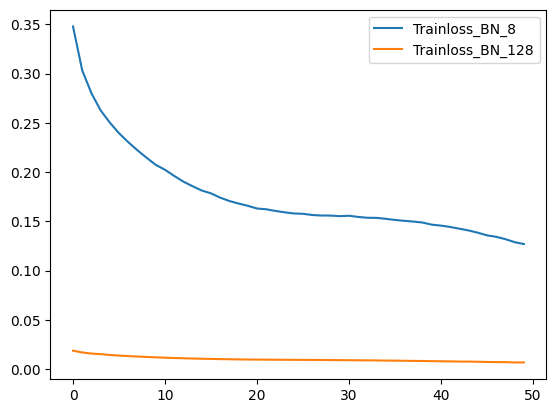

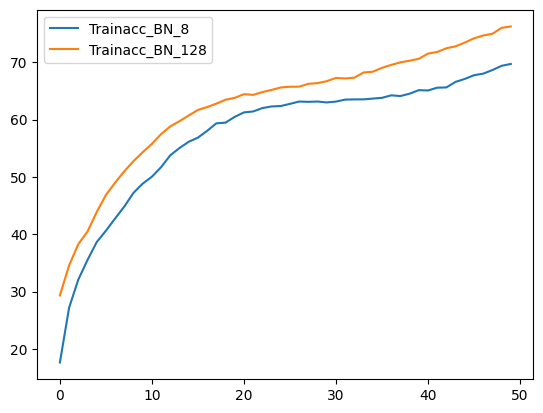

In [5]:
# import torch.cuda as cuda

def training():
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=num_workers)

    train_dataset2 = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/train', transform=transform)
    train_loader2 = DataLoader(train_dataset2, batch_size=128, shuffle=True, num_workers=num_workers)
    
    print("Train Data: ", len(train_dataset))

    net = final_resnet(3, r=25, n=2, norm_type='batch')
    net = nn.DataParallel(net)
    
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.00001)

    train_loss = []
    train_loss2 = []
    train_accuracy = []
    train_accuracy2 = []

    print("------------------------Training Started------------------------")
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        scheduler.step()
        train_loss.append(running_loss/total)
        train_accuracy.append((correct/total)*100)

        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(tqdm(train_loader2)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        scheduler.step()
        train_loss2.append(running_loss/total)
        train_accuracy2.append((correct/total)*100)
        
#         torch.cuda.empty_cache()

        print("Epoch: ", epoch, "Train Loss_8: ", train_loss[-1], "Train Accuracy_8: ", train_accuracy[-1])

        print("Epoch: ", epoch, "Train Loss_128: ", train_loss2[-1], "Train Accuracy_128: ", train_accuracy2[-1])

        print("---------------------------------------------------------------")

        with open('Part2-train_BN(8,128)', 'a') as f:
            f.write("Epoch: " + str(epoch) + " Train Loss_8: " + str(train_loss[-1]) + " Train Accuracy_8: " + str(train_accuracy[-1]) + "\n")
            f.write("Epoch: " + str(epoch) + " Train Loss_128: " + str(train_loss2[-1]) + " Train Accuracy_128: " + str(train_accuracy2[-1]) + "\n")
            f.write("---------------------------------------------------------------\n")

    plt.plot(train_loss, label='Trainloss_BN_8')
    plt.plot(train_loss2, label='Trainloss_BN_128')
    plt.legend()
    plt.show()

    plt.plot(train_accuracy, label='Trainacc_BN_8')
    plt.plot(train_accuracy2, label='Trainacc_BN_128')
    plt.legend()
    plt.show()


training()